# Burundi - Hydrologie Model

In [1]:
'''
File name:              main.ipynb
Author:                 Oliver Carmignani
Date of creation:       2024-09-26
Python Version:         3.10
'''

'\nFile name:              main.ipynb\nAuthor:                 Oliver Carmignani\nDate of creation:       2024-09-26\nPython Version:         3.10\n'

# LOAD MODULES

In [5]:
from pomm import pomm
from pomm.pomm_helper import *
from pomm.pomm_vis import *

ModuleNotFoundError: No module named 'numba'

# INITIALIZE

## Variables and Constants

## Location

## Tif files

### Cut

### Flow Direction

### Accumulation

### Soil

## Rainfall

In [71]:
waga = pd.read_excel('./data/Gisozi_Ruvyironza_Gitega.xlsx')
waga.columns = ['station_name', 'year', 'month', 'day', 'precip']
waga_1 = waga[waga.station_name=='GISOZI'].copy()
waga_2 = waga[waga.station_name=='GITEGA (Aerodrome)'].copy()
waga_3 = waga[waga.station_name=='RUVYIRONZA'].copy()
waga_1.reset_index(inplace=True, drop=True)
waga_2.reset_index(inplace=True, drop=True)
waga_3.reset_index(inplace=True, drop=True)
waga_1['date'] = [datetime.strptime(str(waga_1.year[i]) + '-' + str(waga_1.month[i]) + '-' + str(waga_1.day[i]), '%Y-%m-%d').date() for i in range(waga_1.shape[0])]
waga_2['date'] = [datetime.strptime(str(waga_2.year[i]) + '-' + str(waga_2.month[i]) + '-' + str(waga_2.day[i]), '%Y-%m-%d').date() for i in range(waga_2.shape[0])]
waga_3['date'] = [datetime.strptime(str(waga_3.year[i]) + '-' + str(waga_3.month[i]) + '-' + str(waga_3.day[i]), '%Y-%m-%d').date() for i in range(waga_3.shape[0])]
waga_1.set_index('date', inplace=True)
waga_2.set_index('date', inplace=True)
waga_3.set_index('date', inplace=True)

print(waga_1.shape)
print(waga_2.shape)
print(waga_3.shape)

date_range = pd.date_range(start='2009-01-01', end='2023-12-31', freq='D')
date_range = pd.DataFrame(data={'Zeros': 0}, index=date_range)
waga_concat = date_range.merge(waga_1.precip, how='outer', left_index=True, right_index=True)
waga_concat = waga_concat.merge(waga_2.precip, how='outer', left_index=True, right_index=True)
waga_concat = waga_concat.merge(waga_3.precip, how='outer', left_index=True, right_index=True)
waga_concat.columns = ['drop', 'GISOZI', 'GITEGA (Aerodrome)', 'RUVYIRONZA']
waga_concat = waga_concat[['GISOZI', 'GITEGA (Aerodrome)', 'RUVYIRONZA']]
waga_concat = create_timefeatures(waga_concat)

print()
print(waga_concat.shape)

(5436, 5)
(5463, 5)
(5438, 5)

(5478, 12)


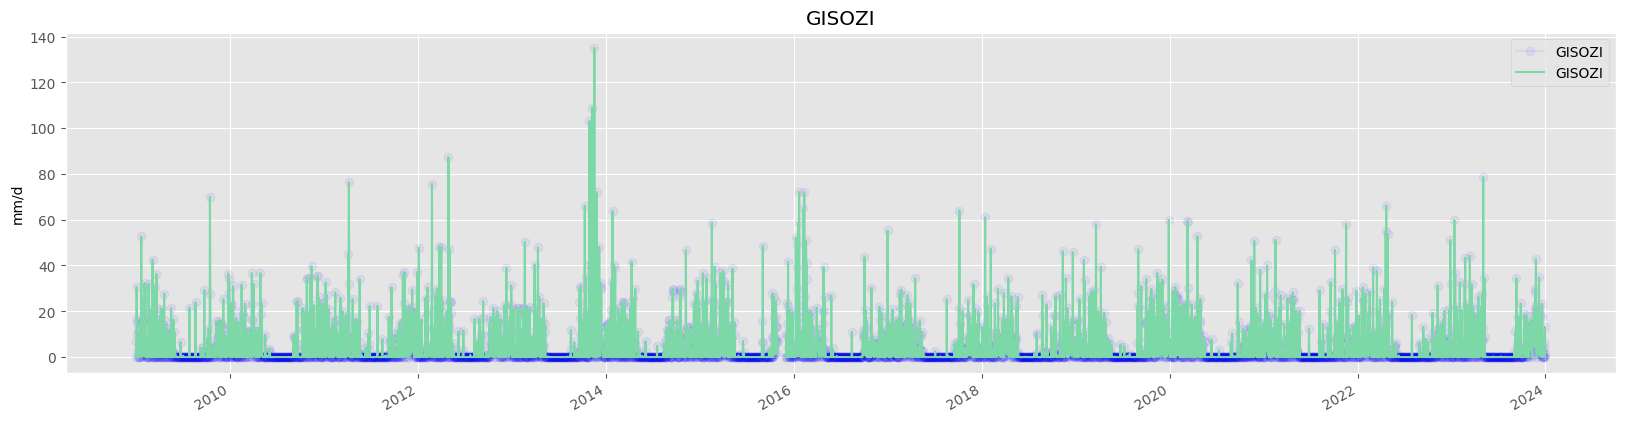

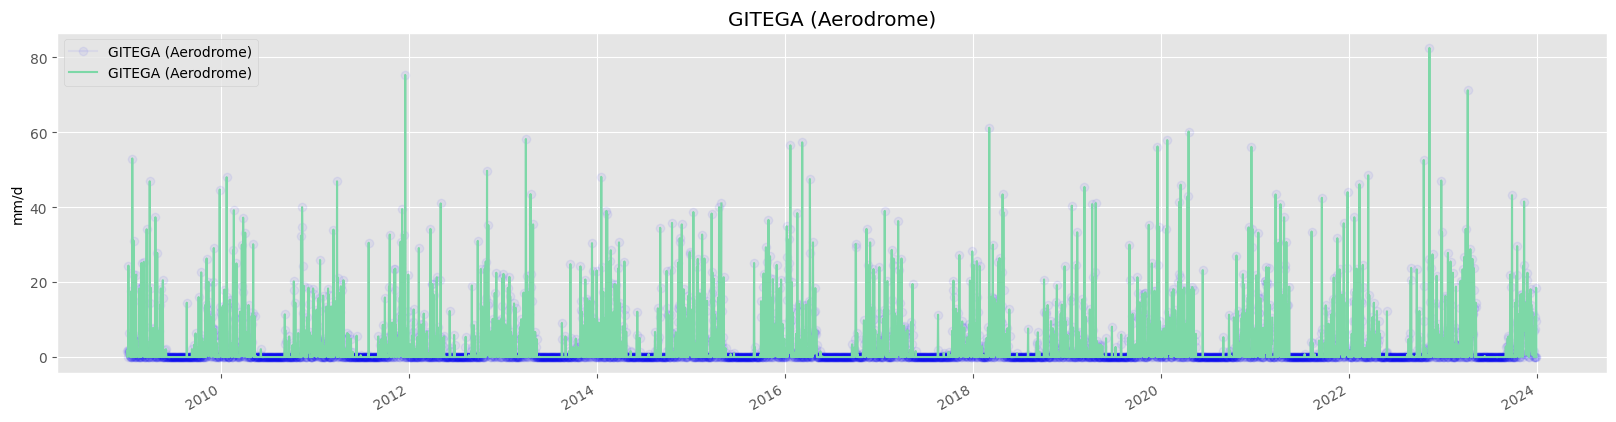

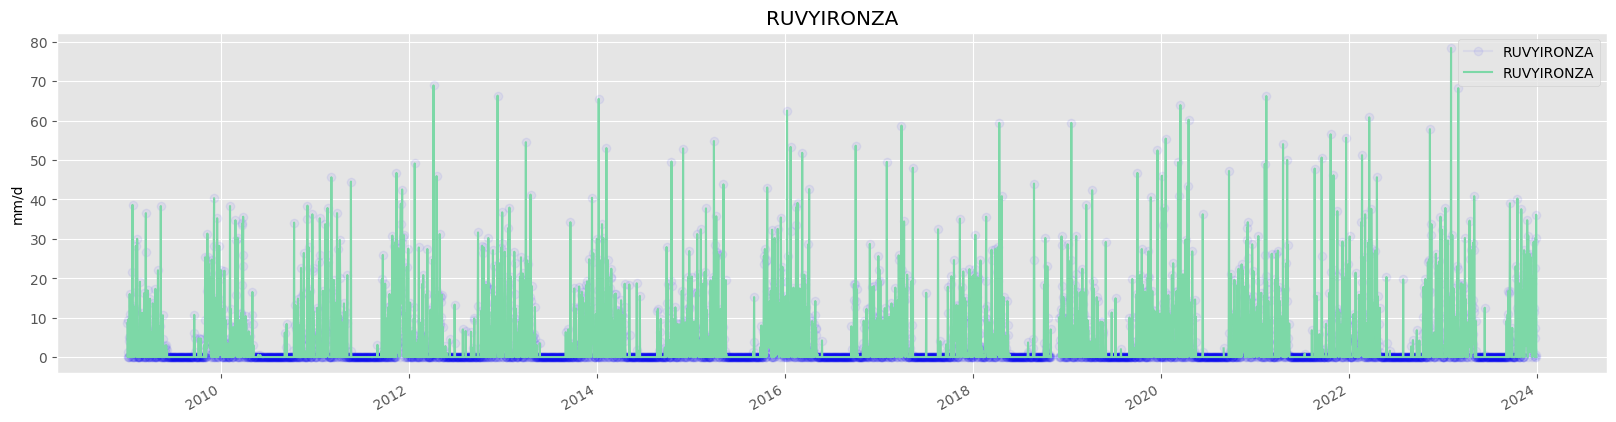

In [72]:
plot_overview(df=waga_concat, key='GISOZI', title='GISOZI', ylabel='mm/d')
plot_overview(df=waga_concat, key='GITEGA (Aerodrome)', title='GITEGA (Aerodrome)', ylabel='mm/d')
plot_overview(df=waga_concat, key='RUVYIRONZA', title='RUVYIRONZA', ylabel='mm/d')

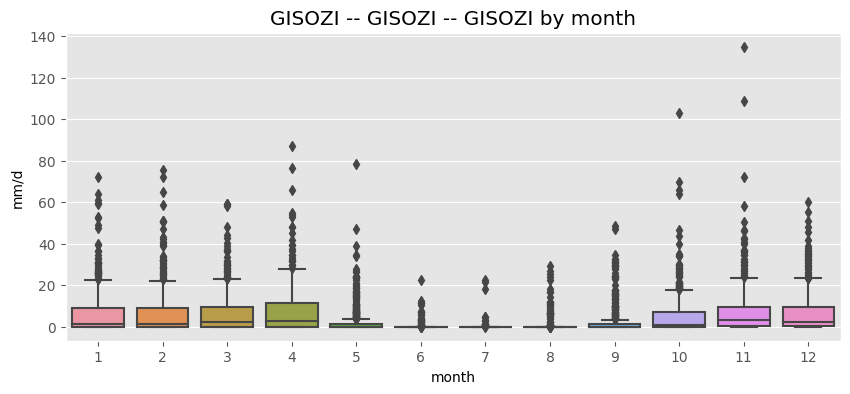

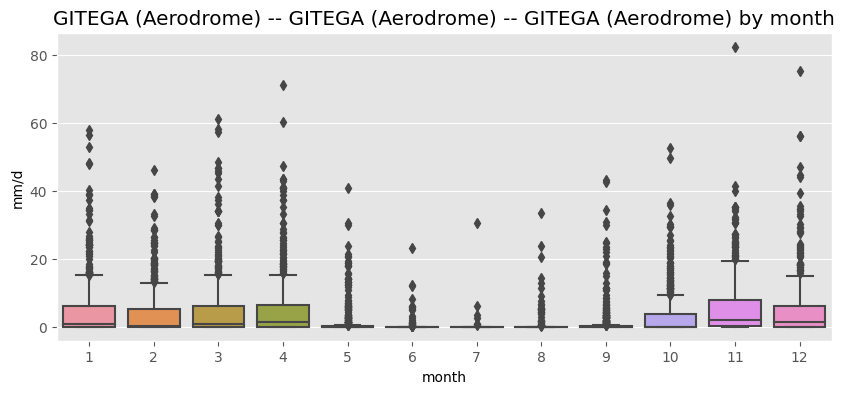

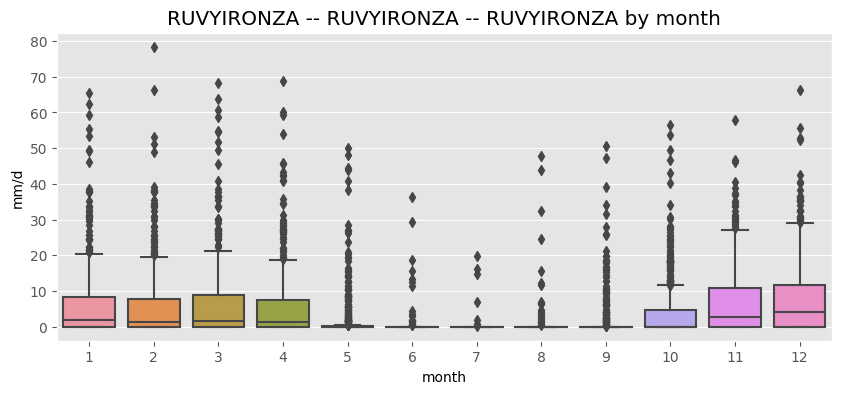

In [74]:
feature_target_relation(df=waga_concat, key='GISOZI', location='GISOZI', name='GISOZI', ylabel='mm/d', feature='month')
feature_target_relation(df=waga_concat, key='GITEGA (Aerodrome)', location='GITEGA (Aerodrome)', name='GITEGA (Aerodrome)', ylabel='mm/d', feature='month')
feature_target_relation(df=waga_concat, key='RUVYIRONZA', location='RUVYIRONZA', name='RUVYIRONZA', ylabel='mm/d', feature='month')

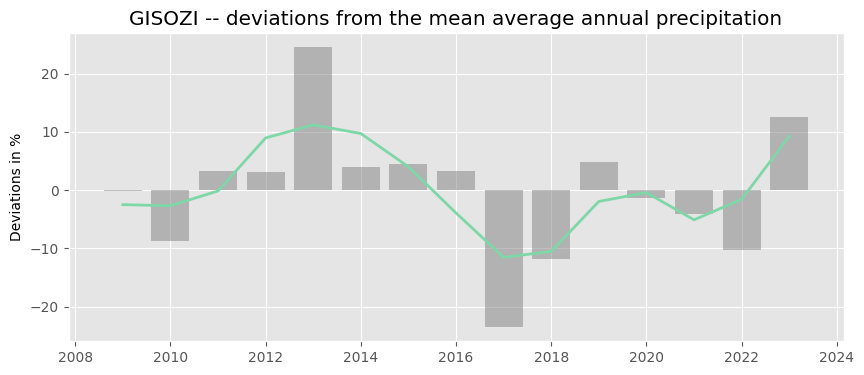

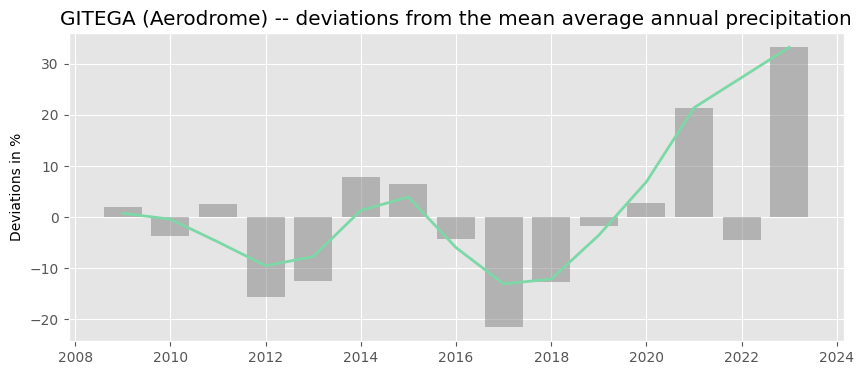

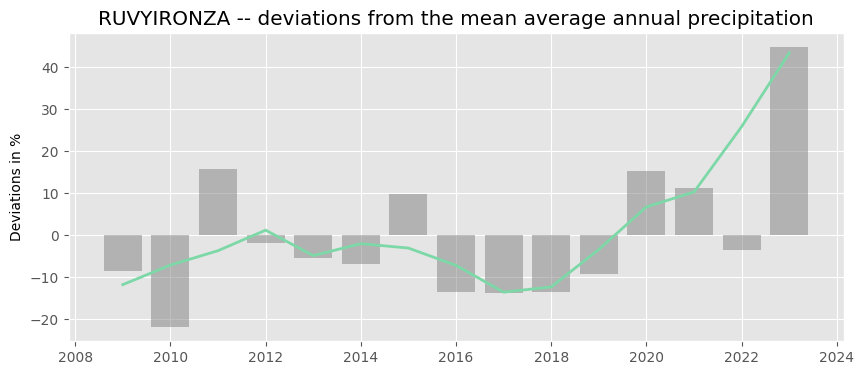

In [76]:
plot_loess(df=waga_concat, key='GISOZI', title='GISOZI -- deviations from the mean average annual precipitation')
plot_loess(df=waga_concat, key='GITEGA (Aerodrome)', title='GITEGA (Aerodrome) -- deviations from the mean average annual precipitation')
plot_loess(df=waga_concat, key='RUVYIRONZA', title='RUVYIRONZA -- deviations from the mean average annual precipitation')

## Runoff

### Ruvyironza

In [99]:
waga_ruvyironza = pd.read_excel('./data/Niveaux_RUVYIRONZA.xlsx')
waga_ruvyironza.columns = ['station_name', 'year', 'month', 'day', 'level']
waga_ruvyironza['date'] = [datetime.strptime(str(waga_ruvyironza.year[i]) + '-' + str(waga_ruvyironza.month[i]) + '-' + str(waga_ruvyironza.day[i]), '%Y-%m-%d').date() for i in range(waga_ruvyironza.shape[0])]
waga_ruvyironza.set_index('date', inplace=True)
date_range = pd.date_range(start='1985-09-01', end='1997-12-31', freq='D')
date_range = pd.DataFrame(data={'Zeros': 0}, index=date_range)
waga_ruvyironza_concat = date_range.merge(waga_ruvyironza.level, how='outer', left_index=True, right_index=True)
waga_ruvyironza_concat = waga_ruvyironza_concat[['level']]
waga_ruvyironza_concat = create_timefeatures(waga_ruvyironza_concat)

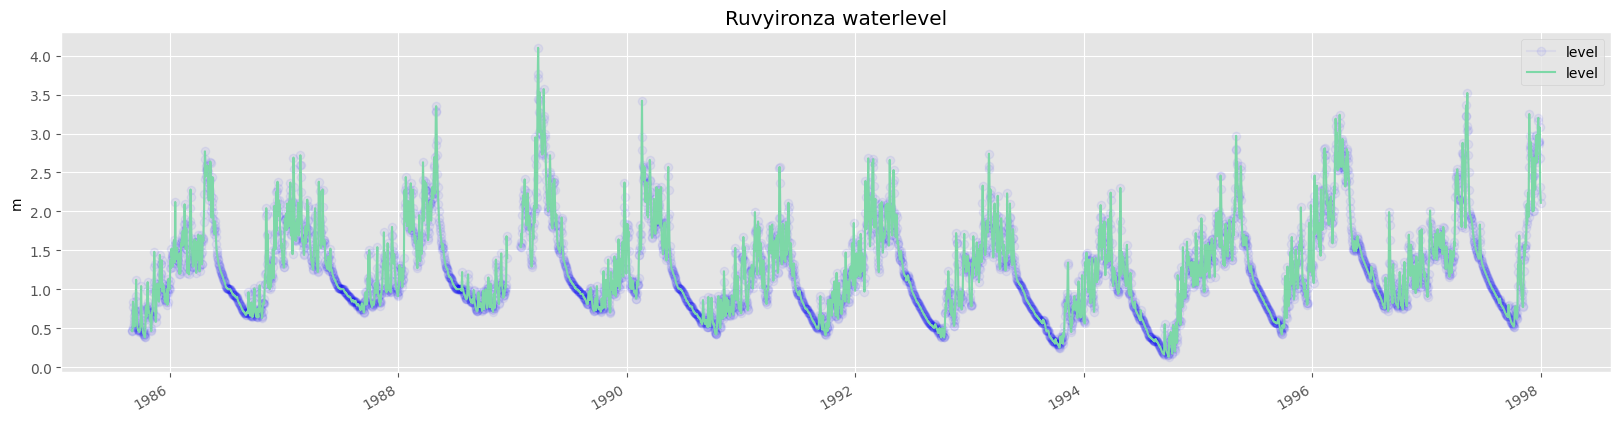

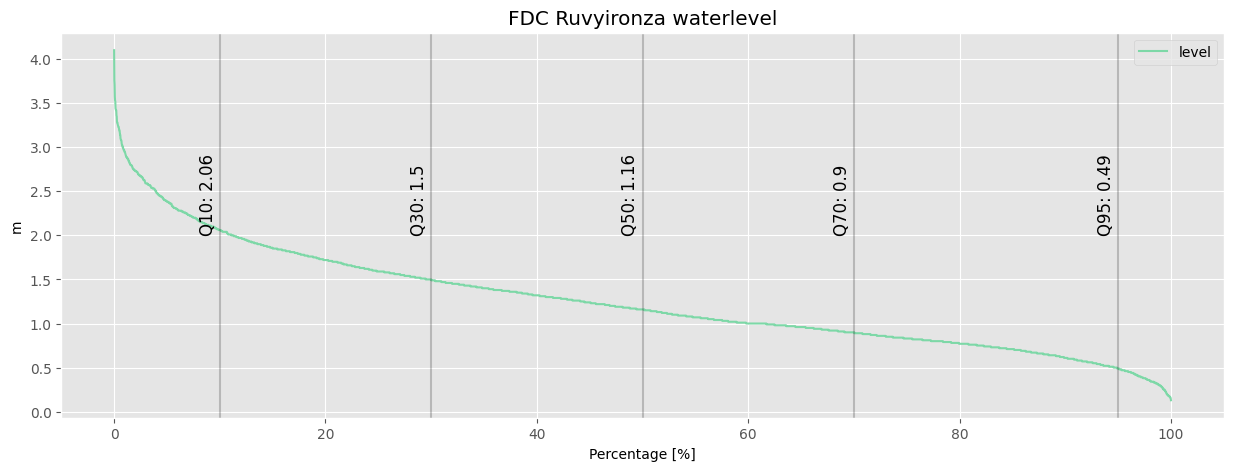

In [115]:
plot_overview(df=waga_ruvyironza_concat, key='level', title='Ruvyironza waterlevel', ylabel='m')
plot_fdc(df=waga_ruvyironza_concat, key='level', ylabel='m', log=False, title='FDC Ruvyironza waterlevel')

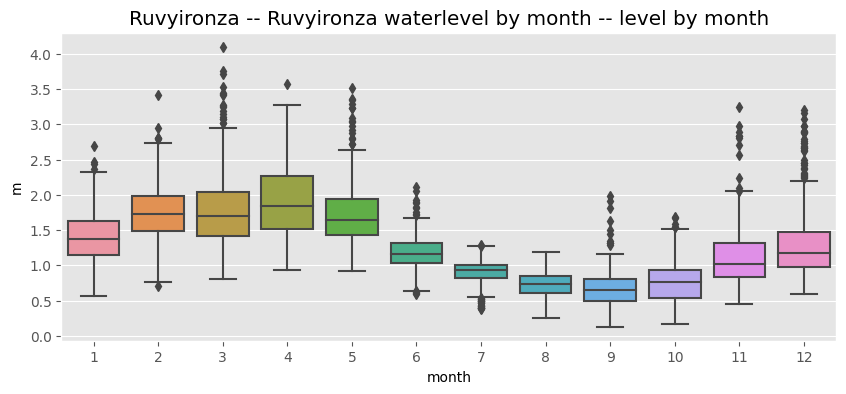

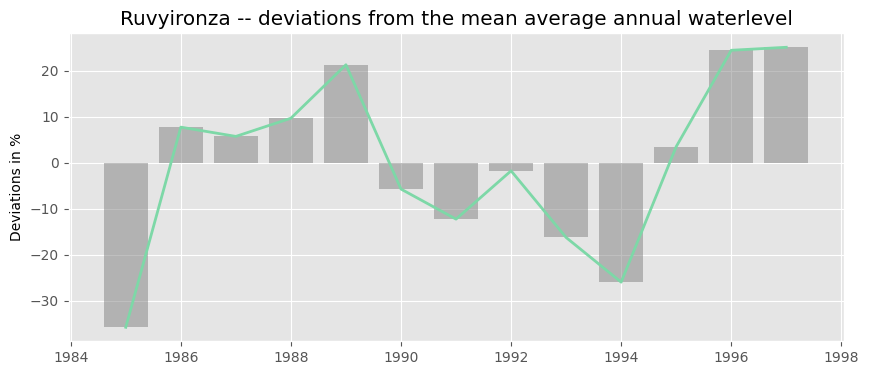

In [110]:
feature_target_relation(df=waga_ruvyironza_concat, key='level', location='Ruvyironza', name='Ruvyironza waterlevel by month', ylabel='m', feature='month')
plot_loess(df=waga_ruvyironza_concat, key='level', title='Ruvyironza -- deviations from the mean average annual waterlevel')

### Nkondo

In [111]:
waga_nkondo = pd.read_excel('./data/Niveaux_NKONDO.xlsx')
waga_nkondo.columns = ['station_name', 'year', 'month', 'day', 'level']
waga_nkondo['date'] = [datetime.strptime(str(waga_nkondo.year[i]) + '-' + str(waga_nkondo.month[i]) + '-' + str(waga_nkondo.day[i]), '%Y-%m-%d').date() for i in range(waga_nkondo.shape[0])]
waga_nkondo.set_index('date', inplace=True)
date_range = pd.date_range(start='2009-01-01', end='2023-12-31', freq='D')
date_range = pd.DataFrame(data={'Zeros': 0}, index=date_range)
waga_nkondo_concat = date_range.merge(waga_nkondo.level, how='outer', left_index=True, right_index=True)
waga_nkondo_concat = waga_nkondo_concat[['level']]
waga_nkondo_concat = create_timefeatures(waga_nkondo_concat)

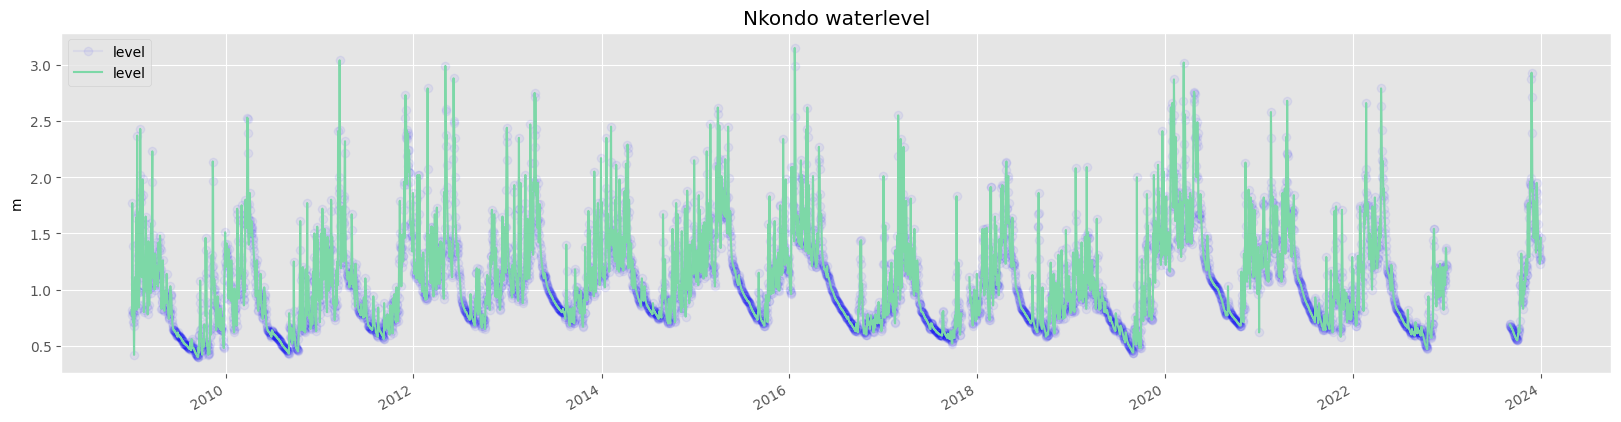

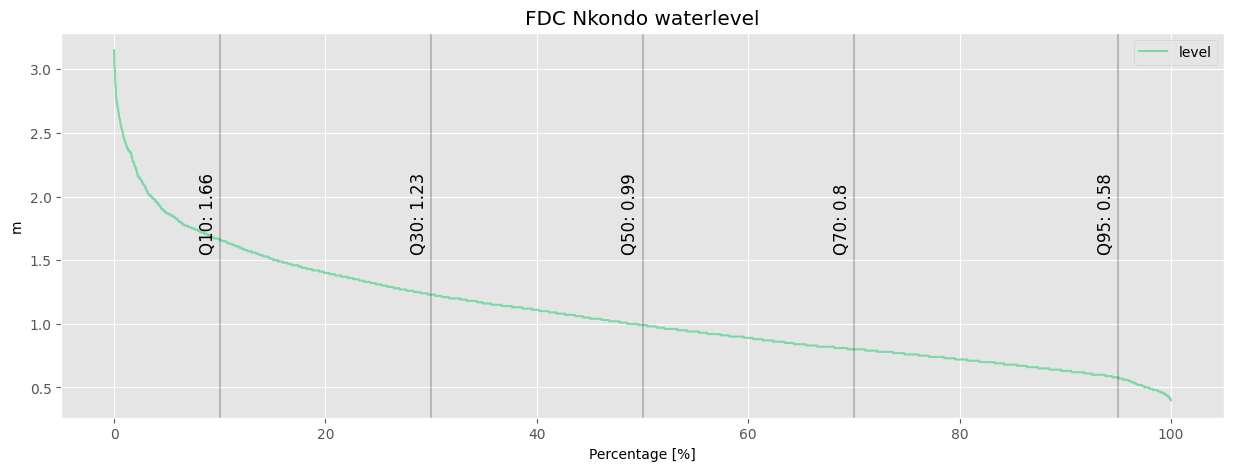

In [112]:
plot_overview(df=waga_nkondo_concat, key='level', title='Nkondo waterlevel', ylabel='m')
plot_fdc(df=waga_nkondo_concat, key='level', ylabel='m', log=False, title='FDC Nkondo waterlevel')

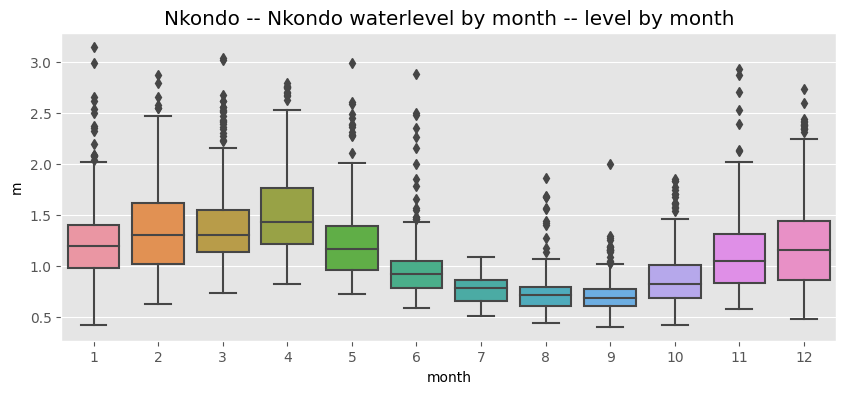

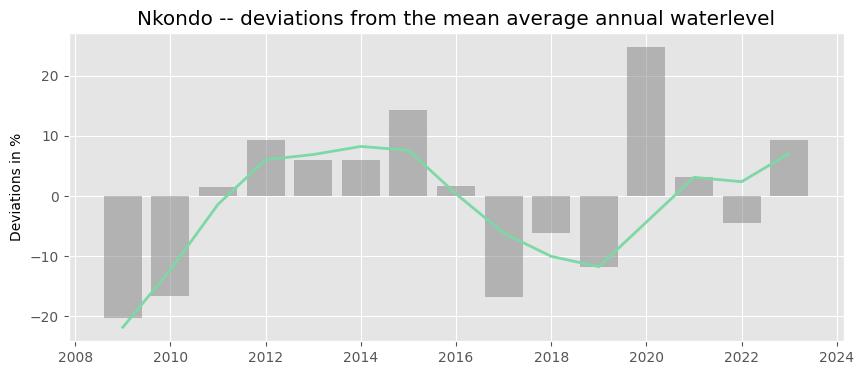

In [113]:
feature_target_relation(df=waga_nkondo_concat, key='level', location='Nkondo', name='Nkondo waterlevel by month', ylabel='m', feature='month')
plot_loess(df=waga_nkondo_concat, key='level', title='Nkondo -- deviations from the mean average annual waterlevel')

### Simu

In [127]:
simu = pd.read_excel('./data/Simu_Hydrology data.xlsx', sheet_name='Simu_Flow')
simu.columns = ['date', 'flow', 'm']
simu = simu[['date', 'flow']]
simu.set_index('date', inplace=True)
simu = create_timefeatures(simu)

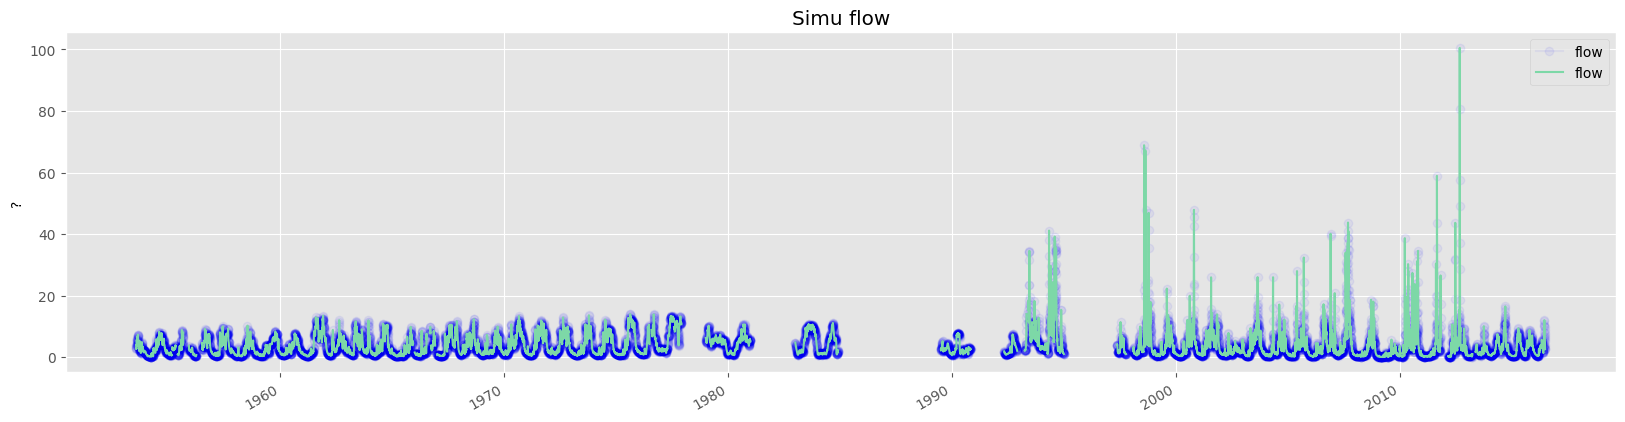

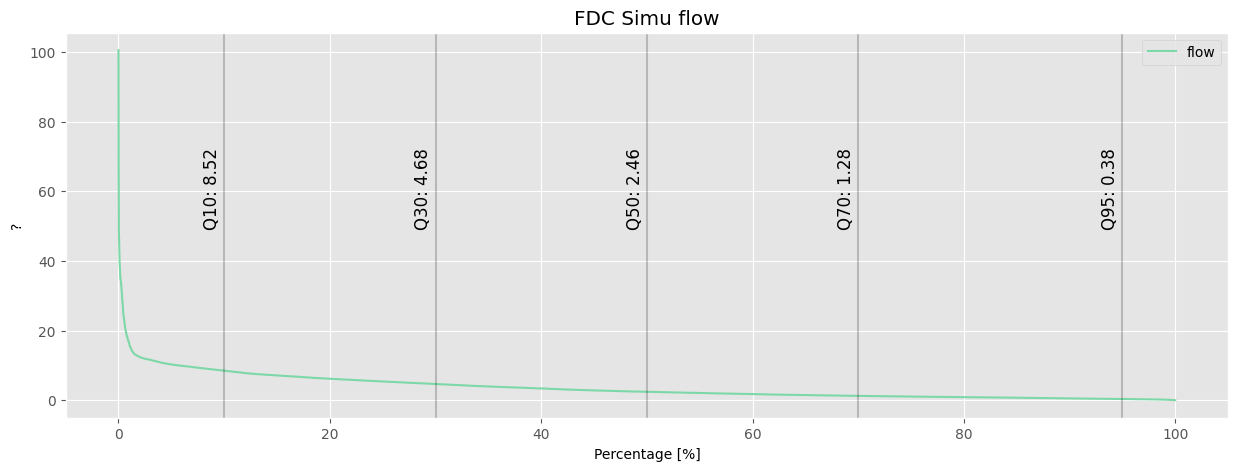

In [128]:
plot_overview(df=simu, key='flow', title='Simu flow', ylabel='?')
plot_fdc(df=simu, key='flow', ylabel='?', log=False, title='FDC Simu flow')

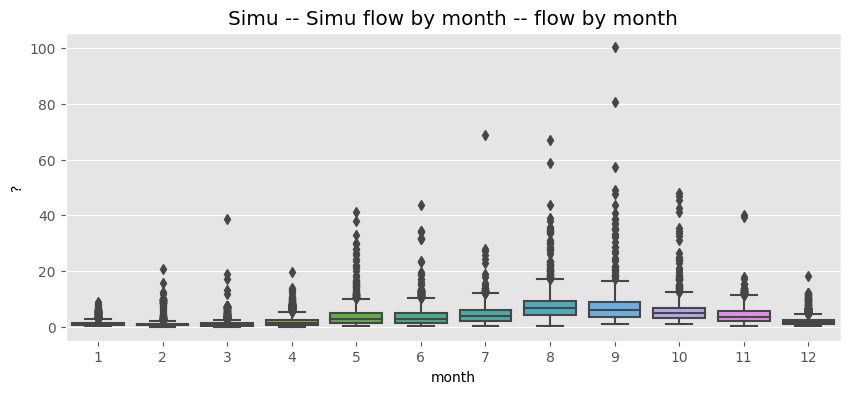

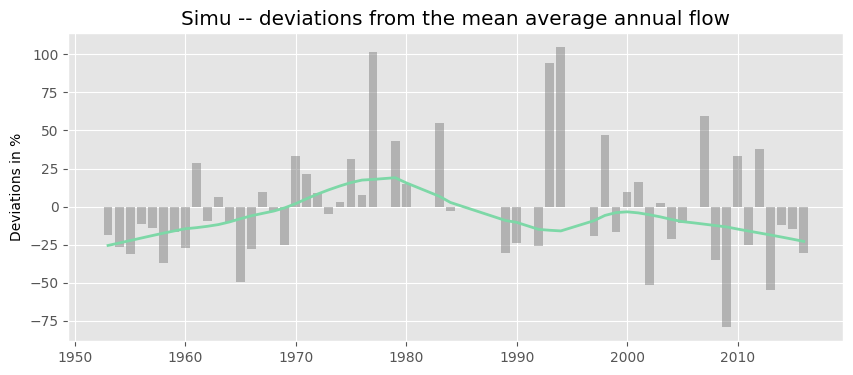

In [129]:
feature_target_relation(df=simu, key='flow', location='Simu', name='Simu flow by month', ylabel='?', feature='month')
plot_loess(df=simu, key='flow', title='Simu -- deviations from the mean average annual flow')

### Sipi

In [135]:
sipi = pd.read_excel('./data/Sipi_Hydrology data.xlsx', sheet_name='Sipi_Flow')
sipi.columns = ['date', 'flow', 'm']
sipi = sipi[['date', 'flow']]
sipi.set_index('date', inplace=True)
sipi = create_timefeatures(sipi)

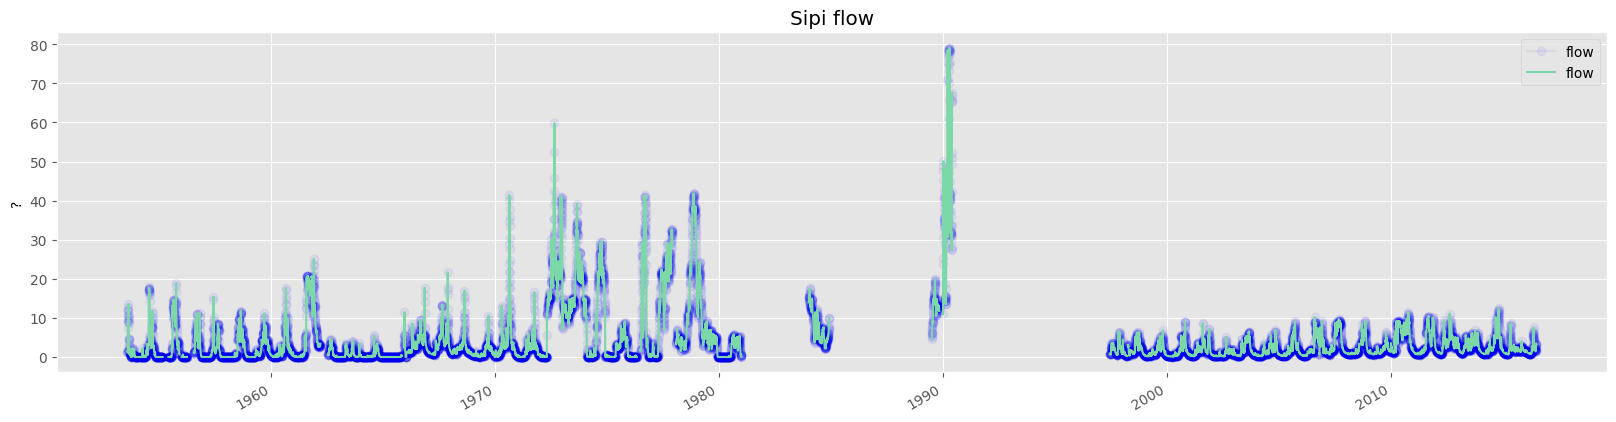

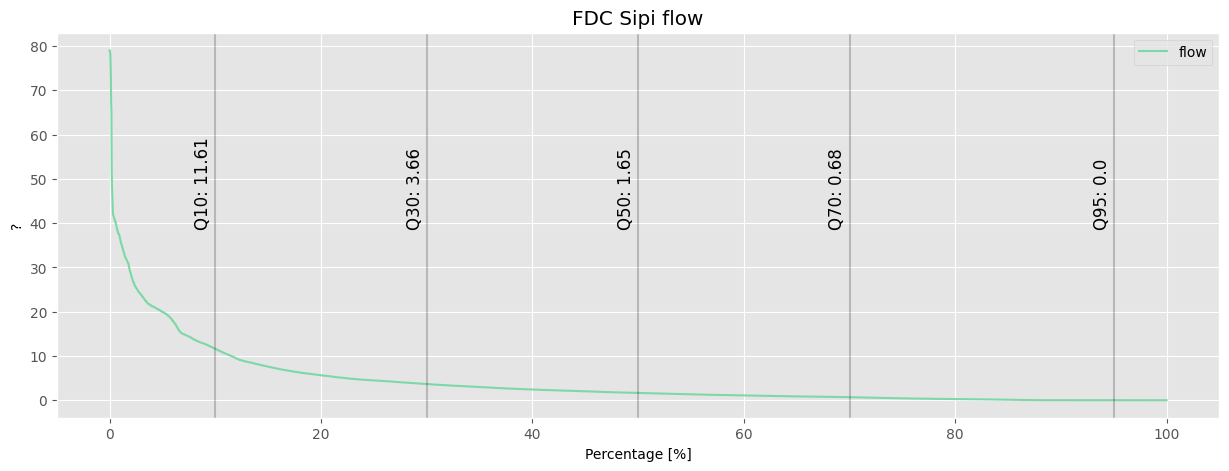

In [133]:
plot_overview(df=sipi, key='flow', title='Sipi flow', ylabel='?')
plot_fdc(df=sipi, key='flow', ylabel='?', log=False, title='FDC Sipi flow')

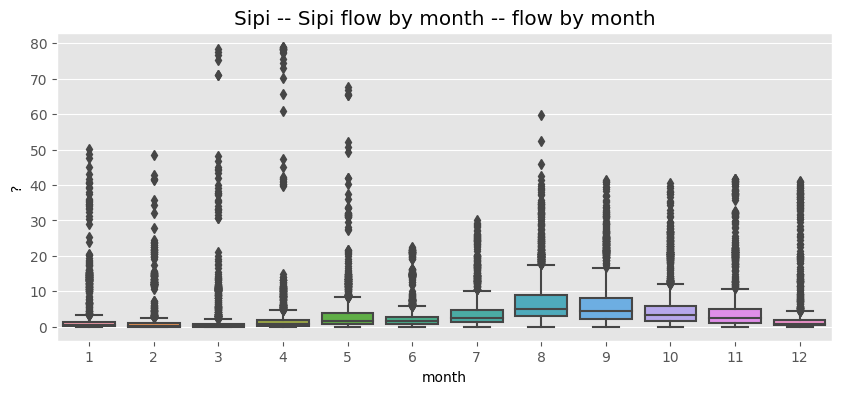

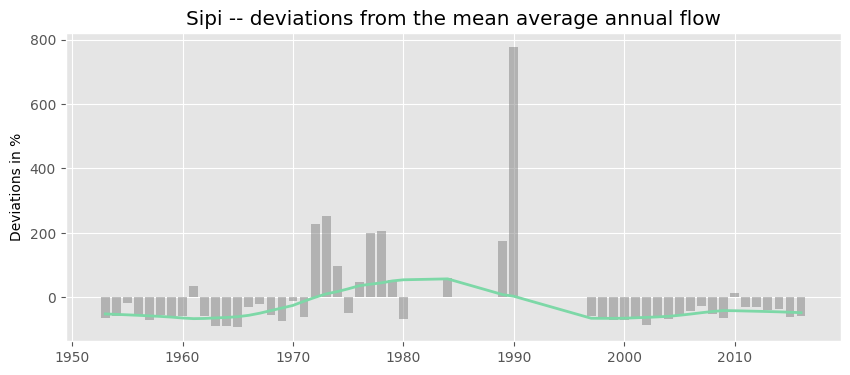

In [134]:
feature_target_relation(df=sipi, key='flow', location='Sipi', name='Sipi flow by month', ylabel='?', feature='month')
plot_loess(df=sipi, key='flow', title='Sipi -- deviations from the mean average annual flow')

### Sironko

In [139]:
sironko = pd.read_excel('./data/Sironko_Hydrology data.xlsx', sheet_name='Sironko_Flow')
sironko.columns = ['date', 'flow', 'm']
sironko = sironko[['date', 'flow']]
sironko.set_index('date', inplace=True)
sironko = create_timefeatures(sironko)

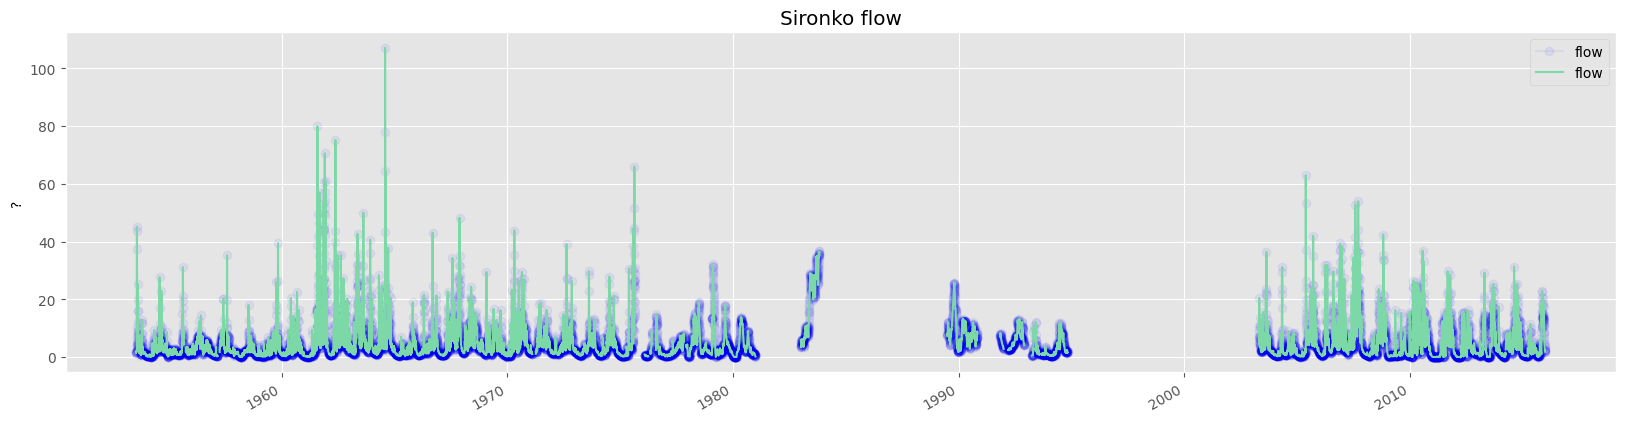

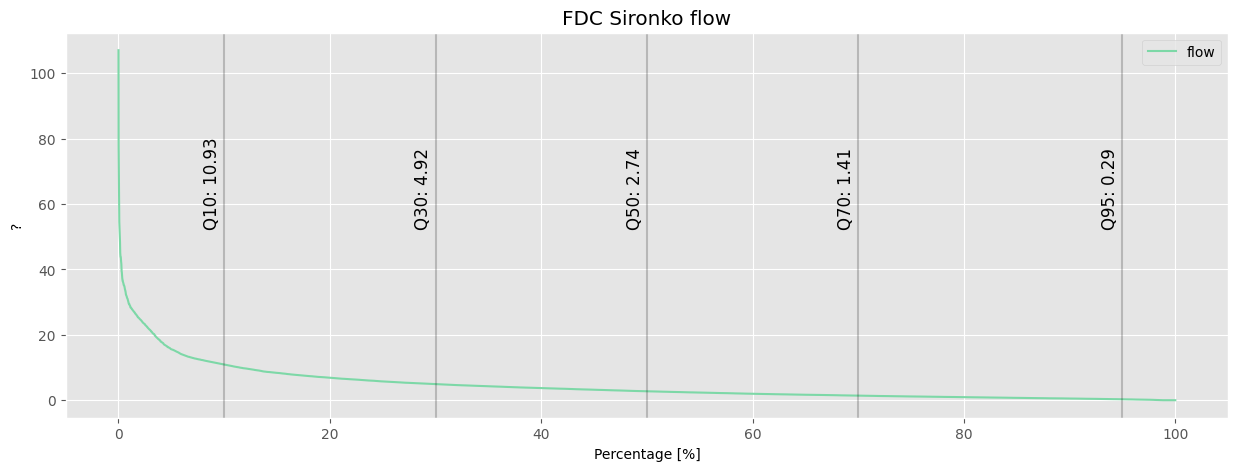

In [140]:
plot_overview(df=sironko, key='flow', title='Sironko flow', ylabel='?')
plot_fdc(df=sironko, key='flow', ylabel='?', log=False, title='FDC Sironko flow')

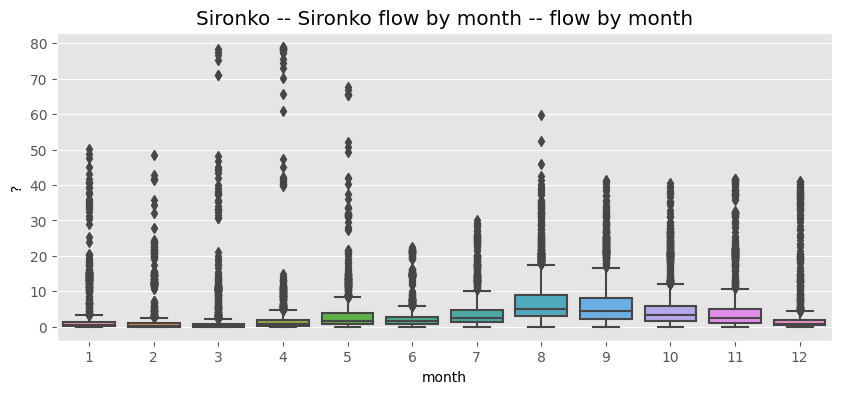

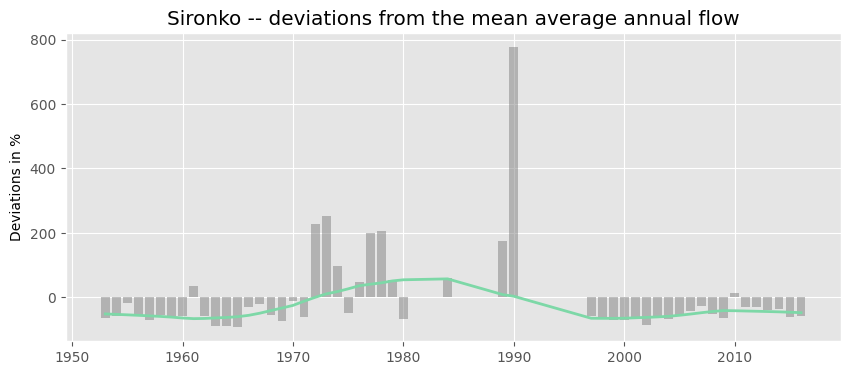

In [138]:
feature_target_relation(df=sironko, key='flow', location='Sironko', name='Sironko flow by month', ylabel='?', feature='month')
plot_loess(df=sironko, key='flow', title='Sironko -- deviations from the mean average annual flow')

## Temperature

## ERA5

## Real world vs Remote Sensing

# MODEL